In [38]:
# comprehensive calculator for EVs, PHEVs, HEVs and ICEs (internal combustion engine vehicles)

def estimate_electric_range_km(battery_size_kwh: float, electric_efficiency: float) -> float:
    """Return the electric range of a PHEV in km
    
    inputs:
        battery_size_kwh: the size of the usable battery in kWh
        electric_fuel_efficiency: the fuel efficiency of the vehicle when running on electric power, in kwh/100km
        
    return the electric range in km
    """
    
    return battery_size_kwh / electric_efficiency * 100


def estimate_fuel_consumption_phev(distance: float, battery_size_kwh: float, electric_efficiency: float, petrol_fuel_efficiency: float,
                                   return_fuel_consumed=False) -> float:
    """Estimate fuel consumption for a PHEV, given its range, electric range, and fuel efficiencies
    
    inputs:
        range: the total distance of the vehicle travelled in km
        battery_size_kwh: the size of the usable battery in kWh
        petrol_fuel_efficiency: the fuel efficiency of the vehicle when running on petrol
        electric_fuel_efficiency: the fuel efficiency of the vehicle when running on electric power, in kwh/100km
        
    
    return the estimated units in L/100km
    """
    
    electric_range_km = estimate_electric_range_km(battery_size_kwh, electric_efficiency)
    
    
    if electric_range_km >= distance:
        return 0
    
    consumed_petrol = (distance - electric_range_km) * petrol_fuel_efficiency / 100
    
    if return_fuel_consumed:
        return consumed_petrol
    
    estimated_fuel_efficiency = consumed_petrol / distance * 100
    
    return estimated_fuel_efficiency


def estimate_petrol_cost(distance: float, petrol_cost_per_litre: float, battery_size_kwh: float, electric_efficiency: float, petrol_fuel_efficiency: float) -> float:
    fuel_consumed = estimate_fuel_consumption_phev(distance, battery_size_kwh, electric_efficiency, petrol_fuel_efficiency, return_fuel_consumed=True)
    cost = fuel_consumed * petrol_cost_per_litre
    return cost


def estimate_total_cost(distance: float, 
                        petrol_cost_per_litre: float, 
                        battery_size_kwh: float, electric_efficiency: float, 
                        petrol_fuel_efficiency: float, 
                        cost_per_kwh: float,
                        ev_road_tax_rate: float,
                        parking_fee: float = 0,
                        exclude_road_tax: bool = False,
                        solar_ratio: float = 0,
                        electric_only=False,
                        recharge_times=1) -> float:
    """Estimate the total cost of a trip in a PHEV
    """
    
    # a cost base of using electricity only, all or partially solar generated/free
    E_COST = distance / 100 * electric_efficiency * cost_per_kwh * (1-solar_ratio)
    if electric_only:
        if exclude_road_tax:
            return E_COST + parking_fee
        else:
            return E_COST + ev_road_tax_rate * distance + parking_fee

    electric_range_km = estimate_electric_range_km(battery_size_kwh, electric_efficiency) * recharge_times
    
    if electric_range_km >= distance:
        # calculate electricity cost
        # print(f'Electricity used: {distance / 100 * electric_efficiency}, cost: {distance / 100 * electric_efficiency * cost_per_kwh}')
        cost = distance / 100 * electric_efficiency * cost_per_kwh * (1-solar_ratio)
    
    else:
        # calculate petrol cost
        fuel_consumed = estimate_fuel_consumption_phev(distance, battery_size_kwh, electric_efficiency, petrol_fuel_efficiency, return_fuel_consumed=True)
        cost = fuel_consumed * petrol_cost_per_litre
        
        # calculate electricity cost
        cost += electric_range_km / 100 * electric_efficiency * cost_per_kwh * (1-solar_ratio)
    
    if exclude_road_tax:
        return cost + parking_fee
    
    return cost + ev_road_tax_rate * distance + parking_fee


cupra_leon_vze = {'battery_size_kwh': 9.8, 'electric_efficiency': 20, 'petrol_fuel_efficiency': 6.5}
economic_factors = {'cost_per_kwh': 0.2, 'petrol_cost_per_litre': 2.2, 'ev_road_tax_rate': 0.023}


distance = 52
fuel_price_AUD = economic_factors['petrol_cost_per_litre']

electric_range = estimate_electric_range_km(cupra_leon_vze['battery_size_kwh'], cupra_leon_vze['electric_efficiency'])


fuel_economy = estimate_fuel_consumption_phev(distance, **cupra_leon_vze)
fuel_consumed = estimate_fuel_consumption_phev(distance, **cupra_leon_vze, return_fuel_consumed=True)
cost = estimate_petrol_cost(distance, fuel_price_AUD, **cupra_leon_vze)


parking_fee = 0
total_cost = estimate_total_cost(distance, **cupra_leon_vze, **economic_factors, parking_fee=parking_fee)
total_cost_without_tax = estimate_total_cost(distance, **cupra_leon_vze, **economic_factors, parking_fee=parking_fee, exclude_road_tax=True)
total_cost_on_solar = estimate_total_cost(distance, **cupra_leon_vze, **economic_factors, parking_fee=parking_fee, solar_ratio=1)
on_solar_without_tax = estimate_total_cost(distance, **cupra_leon_vze, **economic_factors, parking_fee=parking_fee, solar_ratio=1, exclude_road_tax=True)
electric_only = estimate_total_cost(distance, **cupra_leon_vze, **economic_factors, parking_fee=parking_fee, electric_only=True)
electric_only_without_tax = estimate_total_cost(distance, **cupra_leon_vze, **economic_factors, parking_fee=parking_fee, electric_only=True, exclude_road_tax=True)

solar_factor = 1
e_cost_with_solar = estimate_total_cost(distance, **cupra_leon_vze, **economic_factors, parking_fee=parking_fee, solar_ratio=solar_factor, electric_only=True)
e_cost_with_solar_without_tax = estimate_total_cost(distance, **cupra_leon_vze, **economic_factors, parking_fee=parking_fee, solar_ratio=solar_factor, electric_only=True, exclude_road_tax=True)

on_electric_range =  distance if electric_range > distance else electric_range
on_petrol_range = distance - on_electric_range if distance >= electric_range else 0

print(f'Economic Factors: {economic_factors}')
print(f'Car Factors: {cupra_leon_vze}')
print('---------------')
print(f'The Distance Entered: {distance} km, Electric Range: {on_electric_range:.2f} km, Petrol Range: {on_petrol_range:.2f} km')
print(f'Fuel economy estimated: {fuel_economy:.2f}L/100km, Petrol Cost estimated: ${cost:.2f}, Fuel Consumed: {fuel_consumed:.2f}L')
print('---------------')
print(f'Cost with electicity and road tax: ${total_cost:.2f}')
print(f'Zero Tax Equivalence: ${total_cost_without_tax:.2f}')
print('---------------')
print(f'Cost with electicity and road tax, but on an electric range covered by solar: ${total_cost_on_solar:.2f}')
print(f'Zero Tax Equivalence: ${on_solar_without_tax:.2f}')
print('---------------')
print(f'Cost with assumed recharge with electricity (no solar): ${electric_only:.2f}')
print(f'Zero Tax Equivalence: ${electric_only_without_tax:.2f}')
print('---------------')
print(f'Cost with assumed recharge with electricity, but on a solar (free) factor of {solar_factor}: ${e_cost_with_solar:.2f}')
print(f'Zero Tax Equivalence: ${e_cost_with_solar_without_tax:.2f}')
    

Economic Factors: {'cost_per_kwh': 0.2, 'petrol_cost_per_litre': 2.2, 'ev_road_tax_rate': 0.023}
Car Factors: {'battery_size_kwh': 9.8, 'electric_efficiency': 20, 'petrol_fuel_efficiency': 6.5}
---------------
The Distance Entered: 52 km, Electric Range: 49.00 km, Petrol Range: 3.00 km
Fuel economy estimated: 0.37L/100km, Petrol Cost estimated: $0.43, Fuel Consumed: 0.19L
---------------
Cost with electicity and road tax: $3.58
Zero Tax Equivalence: $2.39
---------------
Cost with electicity and road tax, but on an electric range covered by solar: $1.62
Zero Tax Equivalence: $0.43
---------------
Cost with assumed recharge with electricity (no solar): $3.28
Zero Tax Equivalence: $2.08
---------------
Cost with assumed recharge with electricity, but on a solar (free) factor of 1: $1.20
Zero Tax Equivalence: $0.00


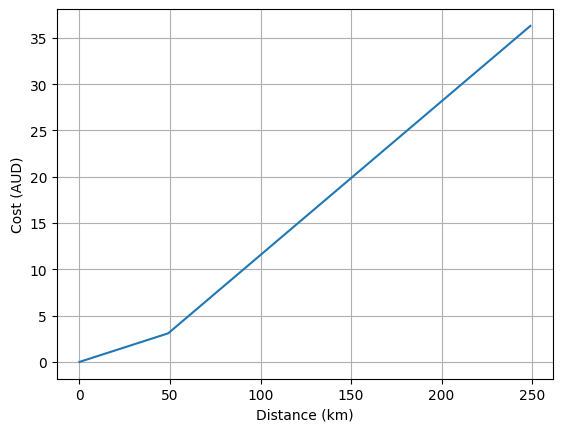

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cost(distance: float, **kwargs):
    x = np.arange(0, distance, 1)
    y = [estimate_total_cost(i, **kwargs) for i in x]
    plt.plot(x, y)
    # labels 
    plt.xlabel('Distance (km)')
    plt.ylabel('Cost (AUD)')
    plt.grid()
    plt.show()
    
def plot_fuel_economy(distance: float, **kwargs):
    x = np.arange(0, distance, 1)
    y = [estimate_fuel_consumption_phev(i, **kwargs) for i in x]
    plt.plot(x, y)
    # labels
    plt.xlabel('Distance (km)')
    plt.ylabel('Fuel Economy (L/100km)')
    plt.grid()
    plt.show()
    
plot_cost(250, **cupra_leon_vze, **economic_factors, parking_fee=0, solar_ratio=0, electric_only=False)

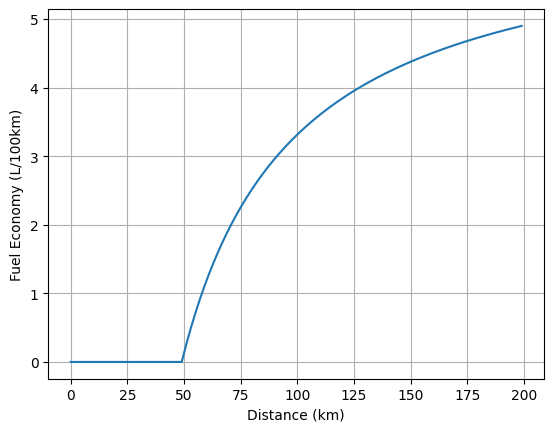

In [41]:
plot_fuel_economy(200, **cupra_leon_vze)